In [5]:
#Implementing my own version of Ridge regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('train.csv')
#train['OverallQual'] = train['OverallQual']**10
train['OverallQual'] = np.exp(train['OverallQual'])
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train.shape

(1458, 81)

In [4]:
def split_array(data,k):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    idx_split = np.array_split(idx,k)
    return idx_split

In [9]:
def crossval(data,output,k,l):
    #data is a numpy array with only numbers
    
    if (data.shape[0]*(k-1)//k) < data.shape[1]:
        print('validation set has less data than number of features')
    #generating random indices
    idx_split = split_array(data,k)
    
    err_matrix = np.zeros(len(idx_split))
    w_matrix = np.zeros((data.shape[1],len(idx_split)))
    
    #split data into training and validation set
    mean_pred = 0
    for i in range(0,len(idx_split)):
        
        validx = idx_split[i]
        val = data[validx,:]
        valo = output[validx]
        tridx =np.concatenate(np.delete(idx_split,i,0))
        tr = data[tridx,:]
        tro = output[tridx]
        
        xTx = np.dot(tr.transpose(),tr)
        L = l*np.identity(tr.shape[1])
        L[0,0]=0
        xTx = xTx+L
        inv = np.linalg.pinv(xTx)
        
        w = inv.dot(tr.transpose()).dot(tro)
        valpred = val.dot(w)
        err = np.sqrt(((np.log(valpred)-np.log(valo))**2).sum()/len(valo))
        
        err_matrix[i] = err
        w_matrix[:,[i]] = w                
    
    return err_matrix.mean(),err_matrix.std(),w_matrix.mean(axis=1)
    

In [94]:
def my_Ridge(data,output,k,m,reg_max):
    ## Preprocess the data that should be a pandas data frame for now
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    ppdf = data.select_dtypes(numerics)
    
    ##replace NaN with column average
    ppdf = ppdf.fillna(ppdf.mean())
    
    # turn input and output into numpy arrays
    cnames = list(ppdf.columns.values)
    ppdf = ppdf.values #convert to numpy array
    output = output.values
    
    ##Detect index column and warn about it
    if np.array(ppdf[ppdf.shape[0]-1,[0]]-ppdf[[0],[0]])==ppdf.shape[0]-1:
        print('First column might be index column. Check data')
    
    ##Normalize all the columns for ridge regression.
    ppdf_norm = (ppdf-ppdf.mean(axis=0))/ppdf.std(axis=0)
    
    
    ##Add the column of ones for the offset
    A = np.ones((ppdf_norm.shape[0],ppdf_norm.shape[1]+1))
    A[:,1:] = ppdf_norm
    ppdf_norm = A
        
    testxTx = np.dot(ppdf_norm.transpose(),ppdf_norm)
    mean_ans = np.zeros(m)
    std_ans = np.zeros(m)

    for l in np.linspace(0,reg_max,m):
        mean_ans[np.where(np.linspace(0,reg_max,m)==l)] = crossval(ppdf_norm,output,k,l)[0]
        std_ans[np.where(np.linspace(0,reg_max,m)==l)] = crossval(ppdf_norm,output,k,l)[1]
        #temporary for debugging purposes
        w_dbg = crossval(ppdf_norm,output,k,l)[2]
    
    y_dbg = np.dot(ppdf_norm,w_dbg)
    plt.errorbar(np.linspace(0,reg_max,m), mean_ans, 0.5*std_ans, marker='o', mfc='red',
         mec='blue', ms=2, mew=4)
    return mean_ans,std_ans,y_dbg,testxTx,ppdf_norm
    

array([0.15510163, 0.15967257, 0.15640767, 0.15328019, 0.15714683,
       0.15296431, 0.15347417, 0.15653756, 0.15872898, 0.15559394,
       0.15406337])

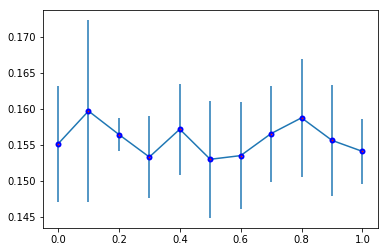

In [97]:
a = my_Ridge(train.iloc[:,1:-1],train.iloc[:,[-1]],5,11,1)
a[0]

In [93]:
a[3][10,10]

1458.000000000005

In [108]:
(a[4][:,1]**2).sum()

1458.0

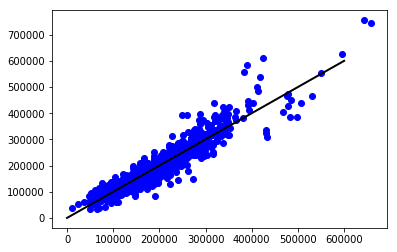

In [100]:
plt.plot(a[2],train.iloc[:,-1].values,'bo')
plt.plot([1, 600000], [1, 600000], 'k-', lw=2)


(array([  2.,   1.,   0.,   0.,   1.,   2.,   2.,   0.,   2.,   2.,   4.,
          7.,  13.,  16.,  34.,  64., 158., 261., 361., 255., 149.,  62.,
         26.,  16.,   8.,   2.,   5.,   1.,   3.,   1.]),
 array([-195870.95692152, -185197.5509698 , -174524.14501807,
        -163850.73906635, -153177.33311462, -142503.9271629 ,
        -131830.52121117, -121157.11525945, -110483.70930773,
         -99810.303356  ,  -89136.89740428,  -78463.49145255,
         -67790.08550083,  -57116.6795491 ,  -46443.27359738,
         -35769.86764566,  -25096.46169393,  -14423.05574221,
          -3749.64979048,    6923.75616124,   17597.16211297,
          28270.56806469,   38943.97401641,   49617.37996814,
          60290.78591986,   70964.19187159,   81637.59782331,
          92311.00377504,  102984.40972676,  113657.81567849,
         124331.22163021]),
 <a list of 30 Patch objects>)

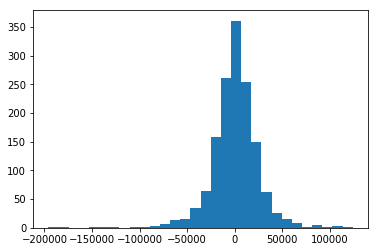

In [20]:
plt.hist(a[2] - train.iloc[:,-1].values,30)